## 实验要求:

### 1. 数据分析、统计

1.  单个特征的分布
2.  统计缺失值
3.  特征间的相关性
4.  推测特征的含义
5.  异常样本
6.  数据抽样

### 2. 特征抽取

1.  特征的变换,如 str 转 int,取 log
2.  尝试组合特征
3.  特征子集选择


In [14]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
sns.set_context("paper")  
sns.set(rc={'figure.figsize': (10, 8)})  # 设置画板大小
sns.set_style('whitegrid')

In [3]:
raw_path = "data/pica2015.csv"
cleaned_path = "data/pica2015_cleaned.csv"

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

## Below is data cleaning process

Include:

1. use mode data to fill the NaN
2. turn `str` and `object` to `int` or `float`
3. drop columns with the same data which means they are unrelated to the classification result
4. do MinMaxscaler to take all the data in [0,1]

Cleaned data has been loaded into "data/pica2015_cleaned.csv"


In [ ]:
df = pd.read_csv(raw_path)

In [ ]:
# actually, we can see from the codebook that columns[5:19] are unrelated to the target variable
# so we can drop them
df.drop(columns=df.columns[5:19], inplace=True)

In [ ]:
# feature type transformation

# temporarily turn nan to -1 for type conversion
df.replace(' ', -1, inplace=True)
# turn column[3] to str
df.iloc[:, 3] = df.iloc[:, 3].astype(str)
# turn the q part to `int`
df.iloc[:, 7:231] = df.iloc[:, 7:231].astype(int)
# turn the v part to `float`
df.iloc[:, 231:-1] = df.iloc[:, 231:-1].astype(float)
# actually null values are ' ' (space), need to change to NaN
df.replace(-1, np.nan, inplace=True)

In [ ]:
# process missing data which is xx9
# turn them into np.nan

max_list = []
for i in range(len(df.columns)):
	ele = df.iloc[:, i].max()
	max_list.append(ele)
for i in range(len(df.columns)):
	if max_list[i] in [9,99,98,998,999,9.0,99.0,98.0,998.0,999.0,95.0]:
		df.iloc[:, i].replace(max_list[i], np.nan, inplace=True)

In [ ]:
# search all the column name with null values
null_columns = df.columns[df.isnull().any()]
# count the number of null values in each column, see those who have more than 10% null value
df[null_columns].isnull().sum()>3000
# actually those who have more than 10% null value are not meaningless, we can neglect them

In [ ]:
# fill the null values with the mode of the column
mode_dict = df[null_columns].mode().iloc[0].astype(int).to_dict()
df.fillna(mode_dict, inplace=True)

In [ ]:
# see the distribution of gender
gender = df['ST004D01T'].value_counts()
gender.plot(kind='pie', autopct='%1.1f%%')

In [ ]:
# samely see the distribution of df.columns[1:10]
# they are all uniformly distributed, therefore meaningless
# delete these columns
df.drop(columns=df.columns[1:11], inplace=True)

In [ ]:
# use MinMaxScaler to normalize the data
df_scaled_np = MinMaxScaler().fit_transform(df)
df_scaled = pd.DataFrame(df_scaled_np, columns=df.columns)

In [ ]:
# save df to cleaned_path
df_scaled.to_csv(cleaned_path, index=False)

In [ ]:
# Below is to see the corresponding meaning of each columns and save to dicts,
# which will give great convenience when I want to refer the meaning of each feature.
cb = pd.read_excel('data/codebook.xlsx')
cb.NAME = cb.NAME.astype(str)
cb.drop(index = cb[cb.NAME=='nan'].index, inplace=True)
col = df.columns.to_numpy()
name = cb.NAME.to_numpy()
zai = []
for i in range(len(name)):
    if name[i] in col:
        zai.append(False)
    else:
        zai.append(True)
cb.drop(index = cb[zai].index, inplace=True)
# load cb's "NAME" and "VARLABEL" to a dict
cb_dict = cb.set_index('NAME').VARLABEL.to_dict()
# load cb_dict to "data/dictionary_cleaned.txt"
cb_dict_path = "data/dictionary_cleaned.txt"
f = open(cb_dict_path, 'w')
f.write(json.dumps(cb_dict, indent=0))

## Clean `finished`

## Below are done on cleaned data.


### 1. Prepare data and tool function.


In [6]:
df = pd.read_csv(cleaned_path)

<AxesSubplot:ylabel='REPEAT'>

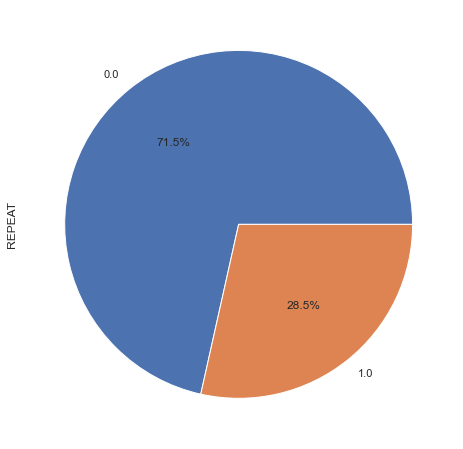

In [7]:
# first, see the distribution of `REPEAT`
rpt = df['REPEAT'].value_counts()
rpt.plot(kind='pie', autopct='%1.1f%%')

In [8]:
# extract the data of `REPEAT`
final_rpt = pd.DataFrame(df['REPEAT'], columns=['REPEAT'])

In [9]:
# make new dataframe from old dataframe according to index_list
def turn_to_list(str):
	begin, end = str.split('~')
	list = [int(i) for i in range(int(begin), int(end)+1)]
	return list

def make_df(df, index_list):
	df_new = pd.DataFrame()
	for i in range(len(index_list)):
		index = index_list[i]
		if(type(index) == int):
			col = df.columns[index]
		else:
			col = index
		df_new[col] = df[col]
	df_new['REPEAT'] = df['REPEAT']
	return df_new

In [154]:
# simply sum all the features with relation to `REPEAT` and standardlize the value
def simplesum_stdlz(df, name):
	if(type(df) == pd.core.frame.DataFrame):
		df = df.to_numpy()
	df = df[:,:-1]
	scaler = StandardScaler()
	df_new = scaler.fit_transform(np.sum(df, axis=1).reshape(-1,1))
	df_new_pd = pd.DataFrame(df_new).rename(columns={0: name})
	return df_new_pd

In [150]:
# sum all the features with relation to `REPEAT` and standardlize the value
def sum_stdlz(map, df, name):
	if(type(df) == pd.core.frame.DataFrame):
		df = df.to_numpy()
	scaler = StandardScaler()
	pn = map.iloc[-2]
	sign = map.iloc[-1][0]
	for i in range(len(pn)-1):
		if(i==0):
			if(sign>0):
				temp = df[:,i]
			else:
				temp = -df[:,i]
		else:
			if ((pn[i]>0 and sign > 0)or(pn[i]<0 and sign < 0)):
				temp = temp + df[:,i]
			else:
				temp = temp - df[:,i]
	df_new = scaler.fit_transform(temp.reshape(-1,1))
	df_new_pd = pd.DataFrame(df_new).rename(columns={0: name})
	return df_new_pd

In [44]:
# draw corr hot map
def draw_corr_map(df,method='pearson'):
	map = df.corr(method=method)
	sns.heatmap(map, annot=True, cmap='coolwarm')
	return map

### 2. divide the features into several parts by hand

parent education: "n" 11 16

study environment: "01" 11 13~16 20 21

life quality:"01" 12 18 19 23-26 "n" 27-35

parent care: "01" 36-39

former rpt: "01" 48-50

study dif: "n": 52-54 "01":55 56

study ambi: "01" 57-64

cooper: "n": 65-72
peer: "01": 73-78

tchr: "01": 79-84

skip: "01": 90-92

schl phnmn1: "n": 116-120
schl phnmn2: "01": 121-129
schl phnmn3: "n": 130-146

sciudstd: "01": 161-165 171-188

sciists: "n": 147-153 166-170 189-197

#### IF the data is yes/no choice, decide to see the correaltion between it and REPEAT

#### ELSE decide to see the regress and box-plot of the data distribution


#### 2.1 Below is to explore parent education level.


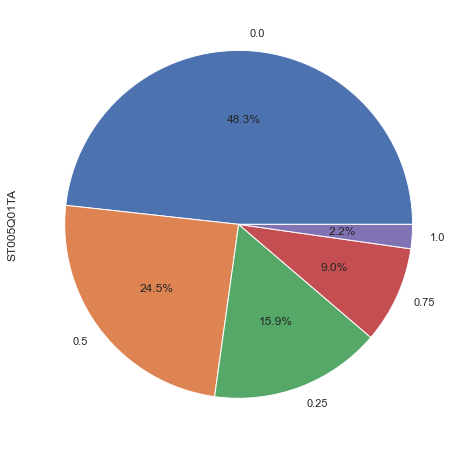

In [46]:
plt_pie(df, 1)

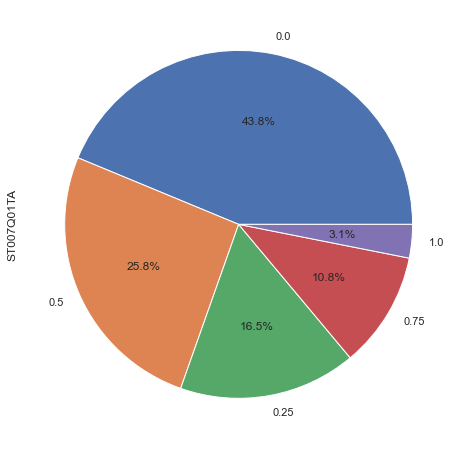

In [47]:
plt_pie(df, 6)

In [48]:
# we can see observe that the distribution of father and mother's education
# level is very similar, so we can mix them to form a new one
prnt_edu_pd = make_df(df,[1,6])

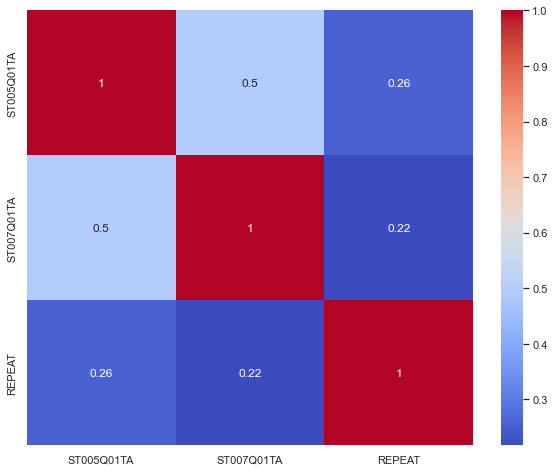

In [51]:
map = draw_corr_map(prnt_edu_pd)

In [52]:
final_prnt_edu = sum_stdlz(map, prnt_edu_pd, 'PRNT_EDU')

,REPEAT,PRNT_EDU
REPEAT,1.000000,0.272723
PRNT_EDU,0.272723,1.000000


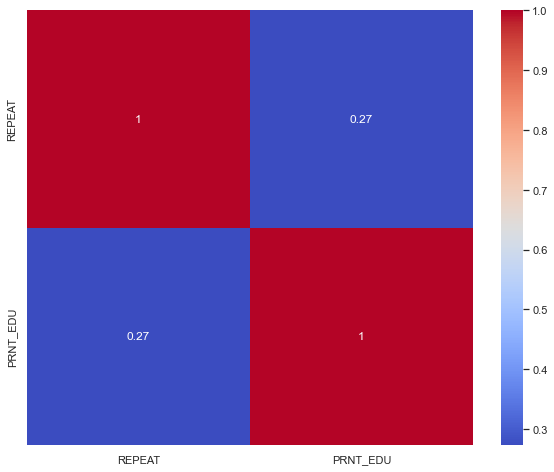

In [53]:
test = pd.concat([final_rpt, final_prnt_edu], axis=1)
draw_corr_map(test)

We can see that the new feature `PRNT_EDU` is meaningful when correlating with `REPEAT`.

Meanwhile, 'Pearson' distance is higher than the other two, which means they are more likely to have linear relationship.


#### 2.2 Below is to observe study environment.


In [54]:
stdy_evrnmt_pd = make_df(df, [11] + turn_to_list('13~16') + [20,21])

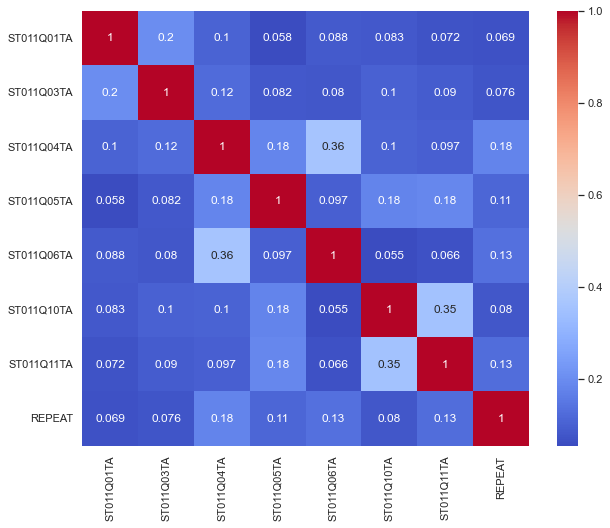

In [55]:
map = draw_corr_map(stdy_evrnmt_pd)

In [56]:
final_stdy_evrnmt = sum_stdlz(map, stdy_evrnmt_pd, 'STUDY_EVRNMT')

,REPEAT,STUDY_EVRNMT
REPEAT,1.000000,0.208432
STUDY_EVRNMT,0.208432,1.000000


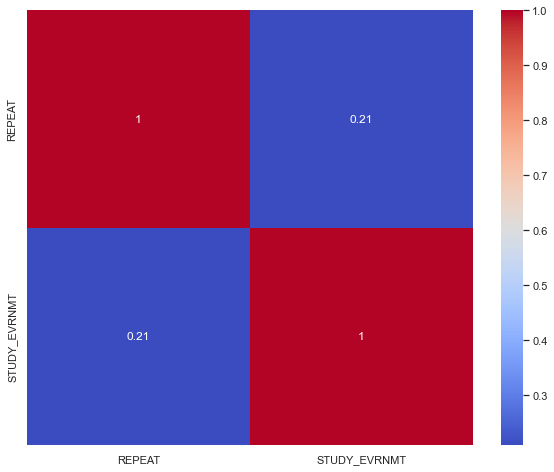

In [57]:
test = pd.concat([final_rpt, final_stdy_evrnmt], axis=1)
draw_corr_map(test, method='pearson')

We can see that the new feature `STUDY_EVRNMT` is meaningful when correlating with `REPEAT`

Pearson distance is also better here.(The other two plot are not showed)


#### 2.3 Below is to observe life quality.


In [58]:
lf_qlty_pd = make_df(df, [12,18,19] + turn_to_list('23~26') + turn_to_list('27~35'))

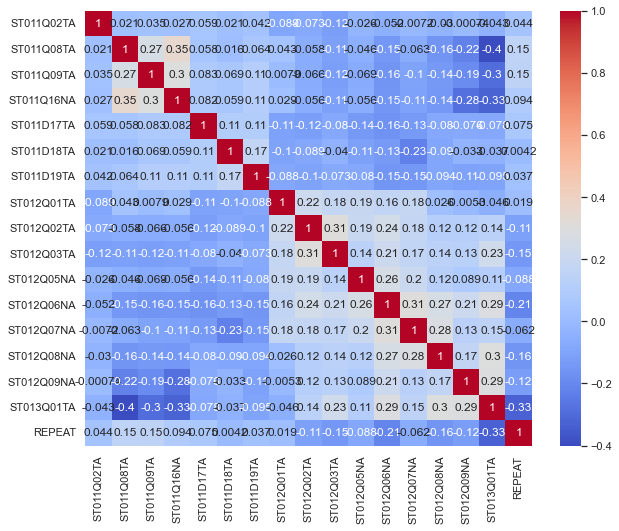

In [59]:
map = draw_corr_map(lf_qlty_pd)

In [60]:
final_lf_qlty = sum_stdlz(map, lf_qlty_pd, 'LF_QLTY')

,LF_QLTY,REPEAT
LF_QLTY,1.000000,-0.251317
REPEAT,-0.251317,1.000000


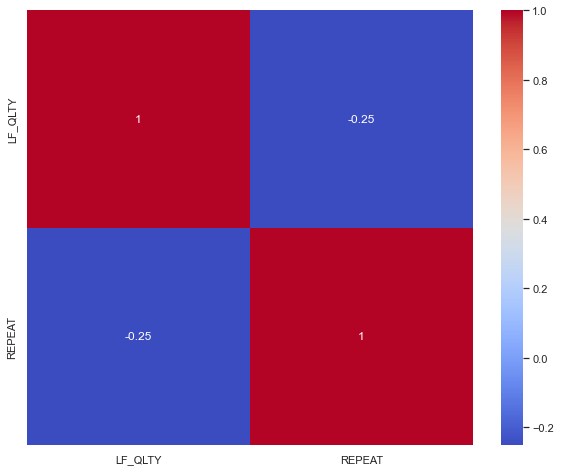

In [61]:
test = pd.concat([final_lf_qlty, final_rpt], axis=1)
draw_corr_map(test, method='pearson')

After trying all the three distance, we find that life-quality seems to have no relationship with `REPEAT`

Decide not to use this feature


#### 2.4 Below is to observe parent care.

In [62]:
prnt_cr_pd = make_df(df, turn_to_list('36~39')) 

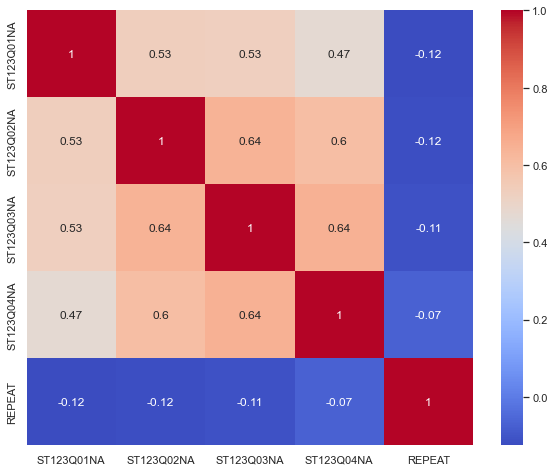

In [63]:
map = draw_corr_map(prnt_cr_pd)

In [64]:
# we can see that this three columns are correlated
# thus we can pick them to form a new dataframe
final_prnt_cr = sum_stdlz(map, prnt_cr_pd, 'PRNT_CR')

,PRNT_CR,REPEAT
PRNT_CR,1.00000,0.12612
REPEAT,0.12612,1.00000


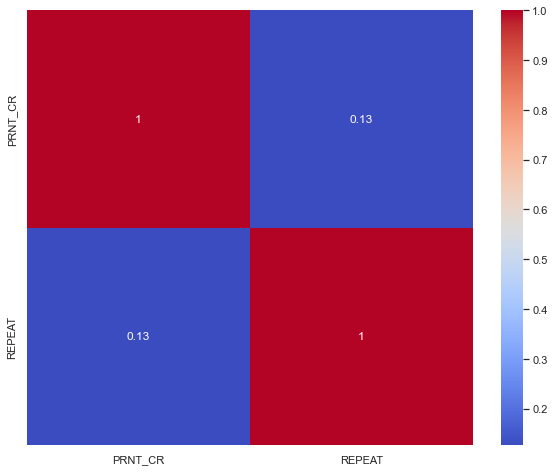

In [65]:
test = pd.concat([final_prnt_cr, final_rpt], axis=1)
draw_corr_map(test, method='pearson')

We can see that the new feature `PRNT_CR` is meaningful when correlating with `REPEAT`

Pearson distance is also better here.(The other two plot are not showed)


#### 2.5 Below is to explore the relationship between `former repeat` and `REPEAT`


In [66]:
ex_rpt_pd = make_df(df, [48,49,50])

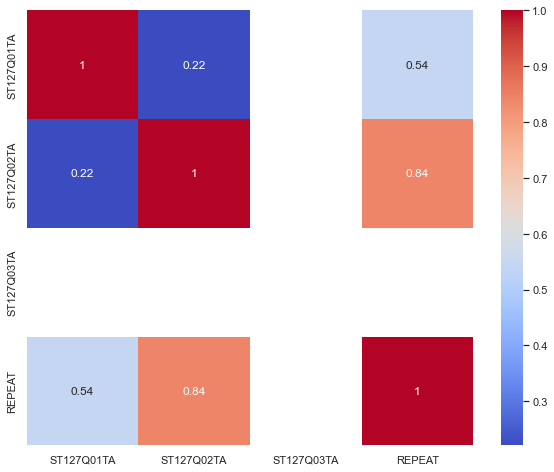

In [67]:
map = draw_corr_map(ex_rpt_pd)

In [ ]:
# check the codebook
# 7 means "no answer"
# I guess that the students haven't reached level 3, therefore it's explained.

In [68]:
ex_rpt_pd = make_df(df, [48,49])

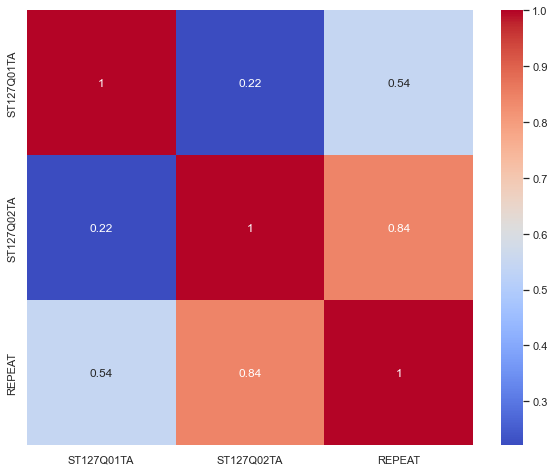

In [69]:
map = draw_corr_map(ex_rpt_pd)

In [70]:
final_ex_rpt = sum_stdlz(map, ex_rpt_pd, 'EX_RPT')

,EX_RPT,REPEAT
EX_RPT,1.00000,0.91077
REPEAT,0.91077,1.00000


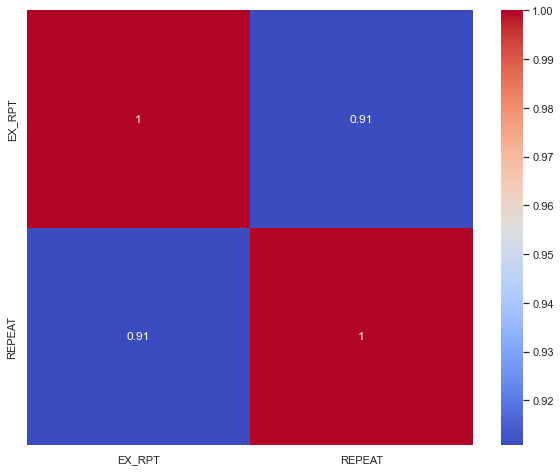

In [71]:
test = pd.concat([final_ex_rpt, final_rpt], axis=1)
draw_corr_map(test, method='pearson')

we can see that the correlation between `REPEAT` and `EX_RPT` is extremely high!

It's easy to understand.

If you repeat one time, then it means you have some trouble with study, whatever the indicator. Therefore, if you keep on studying like this, you are highly likely to repeat again.


#### 2.6 Below is to observe study difficulty and study ambition.


In [72]:
std_diff_pd = make_df(df, [52,53,54,55,56])

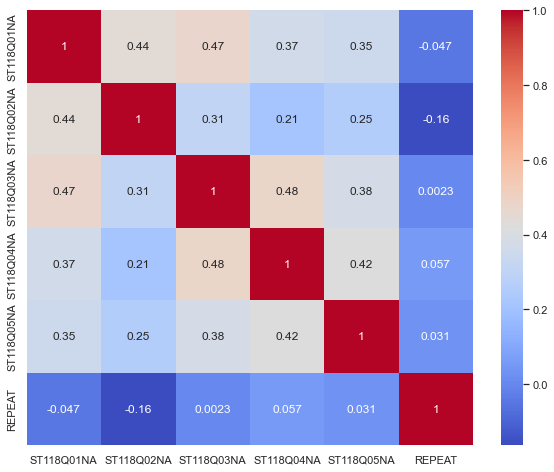

In [160]:
map = draw_corr_map(std_diff_pd)

In [163]:
final_std_diff = sum_stdlz(map, std_diff_pd, 'STD_DIFF')

,STD_DIFF,REPEAT
STD_DIFF,1.000000,0.025099
REPEAT,0.025099,1.000000


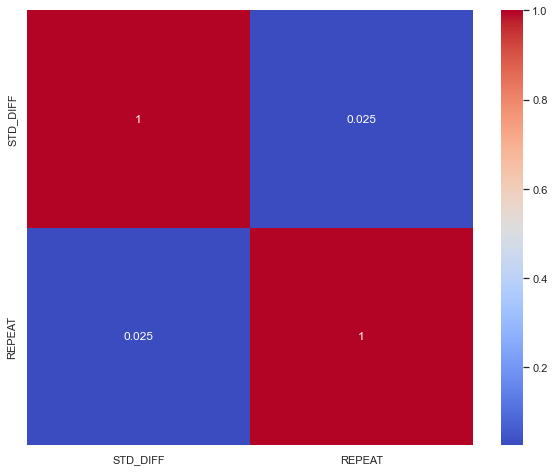

In [164]:
test = pd.concat([final_std_diff, final_rpt], axis=1)
draw_corr_map(test, method='pearson')

,ST118Q02NA,REPEAT
ST118Q02NA,1.000000,-0.164271
REPEAT,-0.164271,1.000000


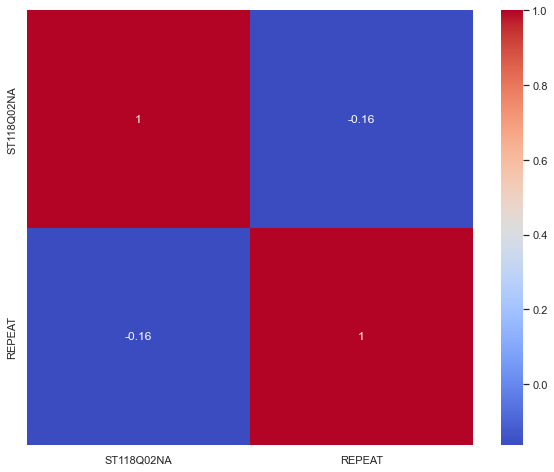

In [166]:
test_pd = make_df(df, [53])
draw_corr_map(test_pd)

We can see that the new feature `STD_DIFF` is unmeaningful when correlating with `REPEAT`

In [81]:
std_ambtn_pd = make_df(df, turn_to_list('57~64'))

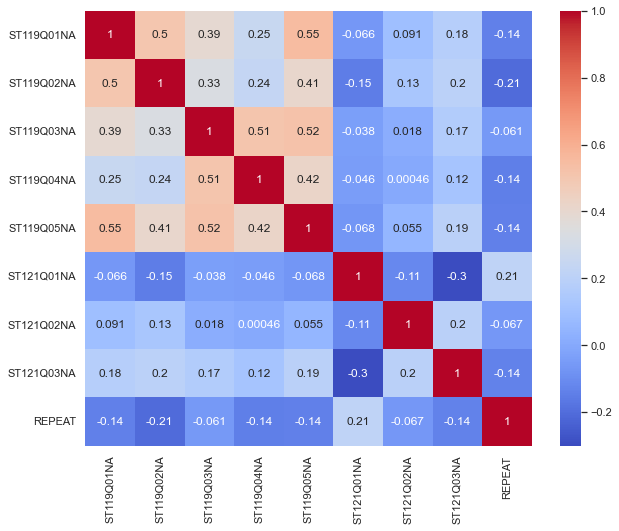

In [82]:
map = draw_corr_map(std_ambtn_pd)

In [83]:
final_std_ambtn = sum_stdlz(map, std_ambtn_pd, 'STD_AMBTN')

,STD_AMBTN,REPEAT
STD_AMBTN,1.00000,0.23383
REPEAT,0.23383,1.00000


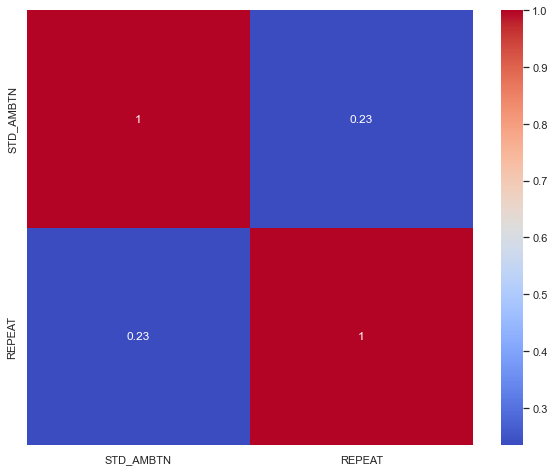

In [84]:
test = pd.concat([final_std_ambtn, final_rpt], axis=1)
draw_corr_map(test, method='pearson')

We can see that the new feature `STD_DIFF` is meaningful when correlating with `REPEAT`

Pearson distance is also better here.(The other two plot are not showed)


#### 2.7 Below is to observe cooperation ability.


In [85]:
coop_pd = make_df(df, turn_to_list('65~72'))

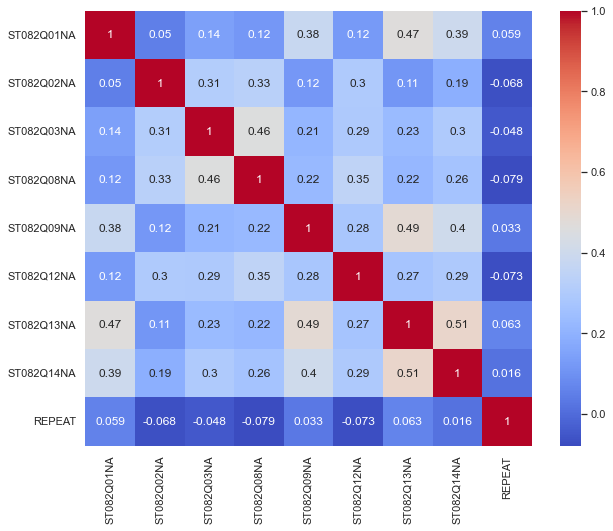

In [86]:
map = draw_corr_map(coop_pd)

In [87]:
final_coop = sum_stdlz(map, coop_pd, 'COOP')

,COOP,REPEAT
COOP,1.000000,-0.006787
REPEAT,-0.006787,1.000000


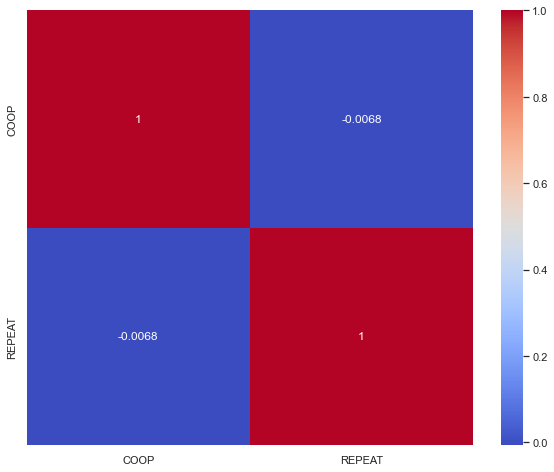

In [88]:
test = pd.concat([final_coop, final_rpt], axis=1)
draw_corr_map(test, method='pearson')

We can see that the new feature `COOP` is meaningless when correlating with `REPEAT`

#### 2.8 Below is to observe peer relationship

In [89]:
peer_pd = make_df(df, turn_to_list('73~78'))

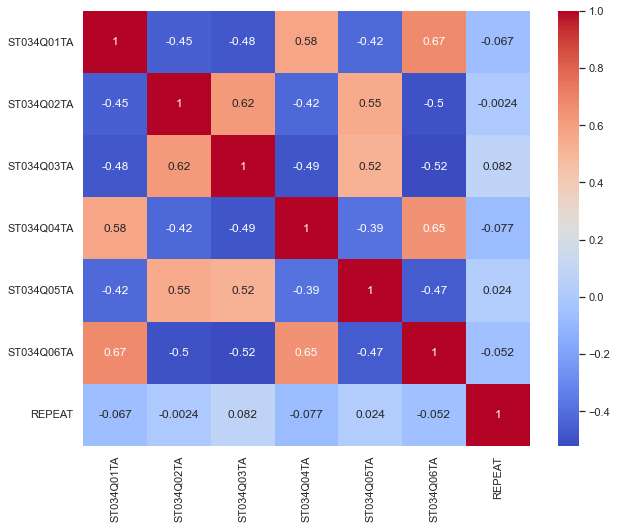

In [90]:
map = draw_corr_map(peer_pd, method='pearson')

In [91]:
final_peer = sum_stdlz(map, peer_pd, 'PEER')

,PEER,REPEAT
PEER,1.00000,0.06573
REPEAT,0.06573,1.00000


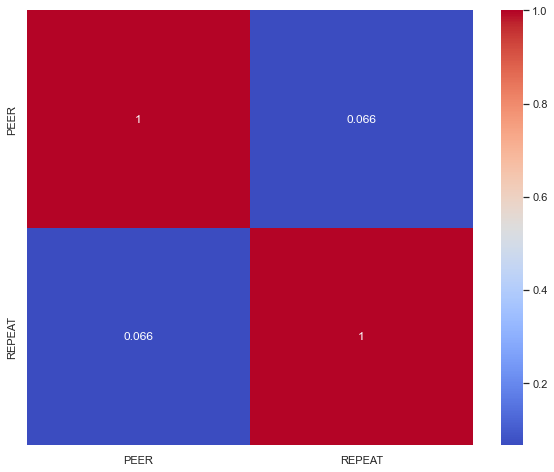

In [96]:
test = pd.concat([final_peer, final_rpt], axis=1)
draw_corr_map(test, method='pearson')

#### 2.9 Below is to observe teacher behavior.


In [111]:
tchr_pd = make_df(df, turn_to_list('79~84'))

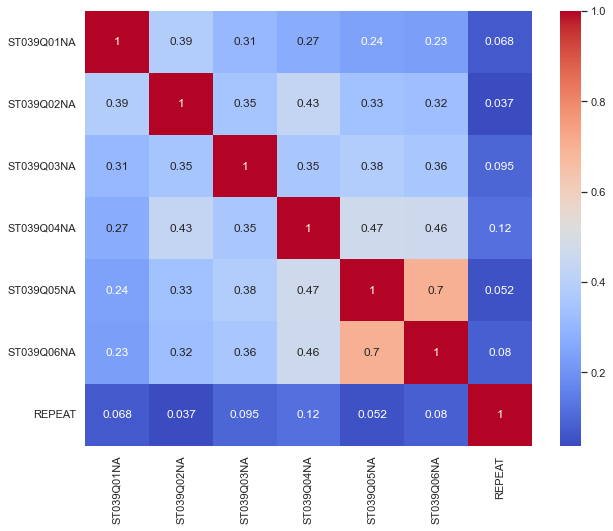

In [120]:
map = draw_corr_map(tchr_pd, method='pearson')

In [158]:
new_tchr_pd = make_df(tchr_pd, [2,3,5])
final_tchr = simplesum_stdlz(new_tchr_pd, 'TCHR')

In [152]:
final_tchr = sum_stdlz(map, tchr_pd, 'TCHR')

,TCHR,REPEAT
TCHR,1.0000,0.1279
REPEAT,0.1279,1.0000


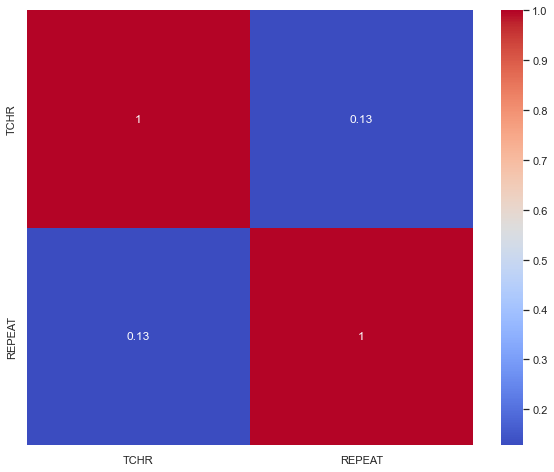

In [159]:
test = pd.concat([final_tchr, final_rpt], axis=1)
draw_corr_map(test, method='pearson')

It's easy to understand. The more harsher, the more likely you will repeat.